# Parallel test to validate assumptions required to do a DiD on a lin-lin specification

In [15]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel('/Users/souhil/Desktop/Courses/Recherche Empirique/Final/Data/cleaned/crimes_subject_to_law_cleaned.xlsx')
df.head()

,year,group,count,population,crime_rate_per_100k
0,2009,Foreigner,4654,NaN,NaN
1,2009,Swiss,4238,NaN,NaN
2,2010,Foreigner,4450,1837112.0,242.23
3,2010,Swiss,4047,6103857.0,66.30
4,2011,Foreigner,4197,1896723.0,221.28


## Visual inspection

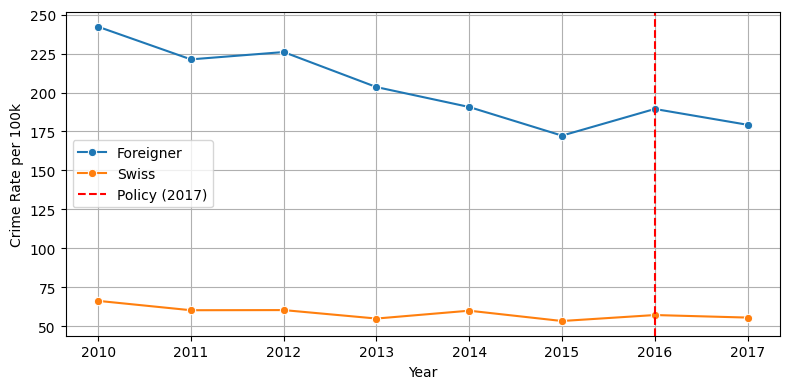

In [16]:
# Clean data (remove rows with missing crime_rate_per_100k)
df = df.dropna(subset=['population'])
df = df[df['crime_rate_per_100k'] > 0].copy()
df = df[df['year'] <= 2017].copy()



plt.figure(figsize=(8,4))
sns.lineplot(data=df, x='year', y='crime_rate_per_100k', hue='group', marker='o')
plt.axvline(2016, color='red', linestyle='--', label='Policy (2017)')
plt.xlabel("Year"); plt.ylabel("Crime Rate per 100k")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig("/Users/souhil/Desktop/Courses/Recherche Empirique/Final/pre_2017_trend_linlin.png", dpi=300, bbox_inches='tight')  
plt.show()

In [17]:
df_pre = df[df['year'] < 2017].copy()  # Ensure pre-treatment data
df_pre['t'] = df_pre['year'] - df_pre['year'].min()  # Center year at earliest value (2009)
df_pre['T'] = (df_pre['group'] == 'Foreigner').astype(int)  # Treatment dummy
df_pre['T_t'] = df_pre['T'] * df_pre['t']  # Interaction term

## Linear Interaction Test

${CrimeRate}_{gt} = \alpha + \gamma T_g + \lambda t + \beta (T_g \times t) + \varepsilon_{gt}$

In [18]:
# Group × Year linear interaction test
m2 = smf.ols("crime_rate_per_100k ~ T + year + T:year", data=df_pre).fit()
print("\n--- Group × Year Interaction Test ---")
print(m2.summary())


--- Group × Year Interaction Test ---
                             OLS Regression Results                            
Dep. Variable:     crime_rate_per_100k   R-squared:                       0.992
Model:                             OLS   Adj. R-squared:                  0.990
Method:                  Least Squares   F-statistic:                     438.1
Date:                 Thu, 05 Jun 2025   Prob (F-statistic):           6.63e-11
Time:                         23:17:15   Log-Likelihood:                -46.211
No. Observations:                   14   AIC:                             100.4
Df Residuals:                       10   BIC:                             103.0
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Int

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=14 observations were given.
  return hypotest_fun_in(*args, **kwds)



## Event-Study Pre-Trends Test

This test is conducted on the canton dataset.

${CrimeRate}_{cgt} = \gamma T_g + \sum_{y=2010}^{2016} \delta_y \cdot \mathbf{1}\{Year = y\} + \sum_{y=2010}^{2016} \theta_y \cdot (T_g \times \mathbf{1}\{Year = y\}) + \alpha_c + \varepsilon_{cgt}$ 

**Null hypothesis**:  
$H_{0}:\;\theta_{2010}=\theta_{2011}=\dots=\theta_{2016}=0.$

In [19]:
df_pre = pd.read_excel("/Users/souhil/Desktop/Courses/Recherche Empirique/Final/Data/cleaned/crimes_subject_to_law_cleaned_by_canton.xlsx")

# Pre‐treatment & log‐transform
df_pre = df_pre[df_pre['year'] < 2017].copy()
df_pre = df_pre[df_pre['crime_rate_per_100k'] > 0]

# Dummies
df_pre['FG'] = (df_pre['group']=='Foreigner').astype(int)
df_pre['year_cat'] = df_pre['year'].astype('category')

# Event‐study regression with canton fixed effects
model = smf.ols("crime_rate_per_100k ~ FG + C(year_cat) + C(year_cat):FG + C(canton)", data=df_pre).fit(cov_type='cluster', cov_kwds={'groups': df_pre['canton']})

print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     crime_rate_per_100k   R-squared:                       0.765
Model:                             OLS   Adj. R-squared:                  0.730
Method:                  Least Squares   F-statistic:                     84.33
Date:                 Thu, 05 Jun 2025   Prob (F-statistic):           1.15e-15
Time:                         23:17:15   Log-Likelihood:                -1367.5
No. Observations:                  272   AIC:                             2807.
Df Residuals:                      236   BIC:                             2937.
Df Model:                           35                                         
Covariance Type:               cluster                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 35, but rank is 13
  warnings.warn('covariance of constraints does not have full '


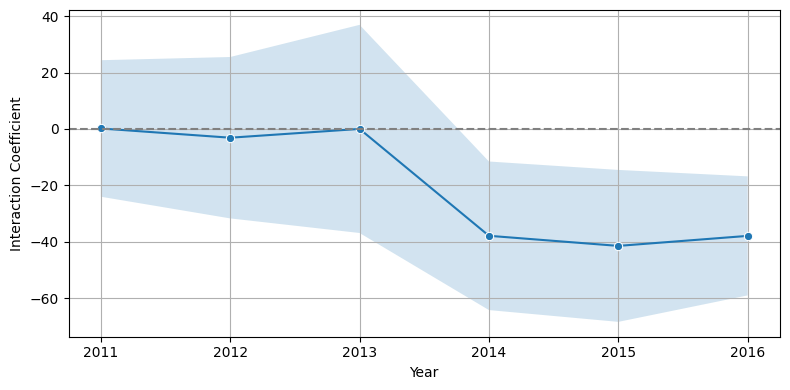

In [20]:
# Extract and plot θ_y = the Foreigner×Year interactions
ints = model.params.filter(like="C(year_cat)[T.").filter(like=":FG")  # Use `like=` as keyword argument
ses = model.bse[ints.index]

# Extract years from coefficient names (e.g., "C(year_cat)[T.2011]:FG" → 2011)
years = [int(s.split('T.')[1].split(']')[0]) for s in ints.index]

# Plot
plt.figure(figsize=(8, 4))
sns.lineplot(x=years, y=ints.values, marker='o')
plt.fill_between(years, ints - 1.96*ses, ints + 1.96*ses, alpha=0.2)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Year"); plt.ylabel("Interaction Coefficient")
plt.grid(True); plt.tight_layout()
plt.savefig("/Users/souhil/Desktop/Courses/Recherche Empirique/Final/foreigner_year_interaction_linear_specification.png", dpi=300, bbox_inches='tight')  
plt.show()

In [21]:
# Get all interaction terms
interaction_terms = [
    term for term in model.params.index 
    if "C(year_cat)[T." in term and ":FG" in term
]

# Formulate the null hypothesis: θ_2011 = θ_2012 = ... = 0
hypothesis = " + ".join(interaction_terms) + " = 0"

# Perform the test
joint_test = model.f_test(hypothesis)
print("\nJoint Test for All Foreigner×Year Interactions = 0")
print(f"F-statistic: {joint_test.fvalue:.2f}")
print(f"p-value: {joint_test.pvalue:.4f}")


Joint Test for All Foreigner×Year Interactions = 0
F-statistic: 5.01
p-value: 0.0356


> **Bottom line:**  We have clear evidence of non parallel trends. A log-specification may be more appropriate. 